# 先運行這個程式碼知道用哪款GPU，是T4再執行，其他的都段開重連

In [ ]:
! /opt/bin/nvidia-smi

Sun Jun 27 18:38:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import 必要元件

In [ ]:
from google.colab import drive
import pandas as pd
import os
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.preprocessing import image
import numpy as np
from keras.models import Model
from keras.utils import np_utils
from keras.datasets import mnist 

from keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Activation, Dropout
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.layers.normalization import BatchNormalization

# 掛載google drive，用gdown下載zip們

In [ ]:
drive.mount('/content/gdrive')
os.chdir('/tmp/')
!gdown --id '1yKG16CRp3YP0kI4wwlOXeU_m02IuS5u0' --output train.zip
!unzip -q train.zip
!gdown --id '10VGqMy7gy1Pvqg-E2q8vLrVC9Bbds1o2' --output test.zip
!unzip -q test.zip

Mounted at /content/gdrive
Downloading...
From: https://drive.google.com/uc?id=1yKG16CRp3YP0kI4wwlOXeU_m02IuS5u0
To: /tmp/train.zip
1.39GB [00:09, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=10VGqMy7gy1Pvqg-E2q8vLrVC9Bbds1o2
To: /tmp/test.zip
339MB [00:04, 70.6MB/s]


# 使matplotlib可以顯示中文

In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

# 從 Google API 上下載字體放到暫存資料夾底下
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# 指定字體
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"


--2021-06-27 18:40:57--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.31.128, 2607:f8b0:4004:c0b::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   209MB/s    in 0.6s    

2021-06-27 18:40:58 (209 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  
  inflating: 

# 資料前處理開始
## 將資料train切進base，將資料test切進test

In [ ]:
base_dir = '/tmp/train'
test_dir = '/tmp/test'
seed=42
img_height=224
img_width=224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed = seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
class_names = train_ds.class_names
#train_ds = train_ds.reshape(22347,224,224,4)
#val_ds = val_ds.reshape(5586,224,224,4)
#train_ds = np.expand_dims(train_ds, axis=4)
#val_ds = np.expand_dims(val_ds, axis=4)

Found 27933 files belonging to 50 classes.
Using 22347 files for training.
Found 7006 files belonging to 50 classes.
Using 1401 files for validation.


## 確認batch_size大小的資料是否有被存進numpy確認batch_size大小的資料是否有被存進numpy

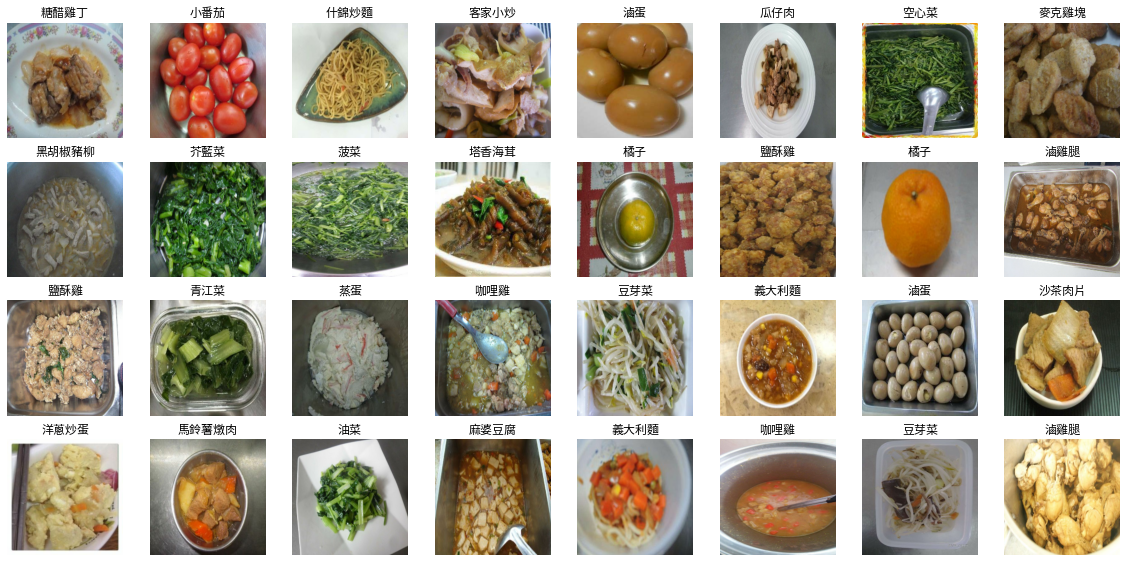

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## AUTOTUNE，可以使其更有效率使用CPU

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## data_augmentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = keras.Sequential(
  [
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomTranslation(height_factor=0.1,width_factor=0.1),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
  ]
)

## 開始建model的layer們

In [ ]:
img_input = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(img_input)
x = preprocessing.Rescaling(1./255)(x)

# model本身參數調整，詳情請見PPT

1.先試不同的model

2.再改不同的optimizer

3.再改不同的learning_rate和decay

4.再改不同的Freeze layers

5.細微調整參數驗證趨勢



In [ ]:
model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
NUM_CLASSES=50
# Freeze the pretrained weights
"""
layer_above_to_freese=60
for layer in model.layers[:layer_above_to_freese]:
  layer.trainable=False
for layer in model.layers[layer_above_to_freese:]:
  layer.trainable=True
"""
# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(img_input,outputs,name="E14073190")
model.compile(loss='sparse_categorical_crossentropy',
       optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.04,decay=0.01),
       metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5 accuracy")]
)
model.summary()

43941888/43941136 [==============================] - 0s 0us/step
Model: "E14073190"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_translation (RandomTrans (None, 224, 224, 3)  0           random_flip[0][0]                
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 224, 224, 3)  0           random_translation[0][0]         
_________________________

# 開始model.fit，設定epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
epochs=13
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback,model_checkpoint_callback]
)
model.load_weights(checkpoint_filepath) #載入目前最好的weight設定

Epoch 1/13
699/699 [==============================] - 480s 622ms/step - loss: 1.6079 - accuracy: 0.5577 - top5 accuracy: 0.8631 - val_loss: 6.9623 - val_accuracy: 0.0493 - val_top5 accuracy: 0.2434
Epoch 2/13
699/699 [==============================] - 433s 618ms/step - loss: 0.8306 - accuracy: 0.7299 - top5 accuracy: 0.9624 - val_loss: 1.4487 - val_accuracy: 0.5946 - val_top5 accuracy: 0.8972
Epoch 3/13
699/699 [==============================] - 432s 618ms/step - loss: 0.7345 - accuracy: 0.7596 - top5 accuracy: 0.9697 - val_loss: 0.9110 - val_accuracy: 0.7159 - val_top5 accuracy: 0.9550
Epoch 4/13
699/699 [==============================] - 432s 617ms/step - loss: 0.6785 - accuracy: 0.7767 - top5 accuracy: 0.9756 - val_loss: 0.7773 - val_accuracy: 0.7480 - val_top5 accuracy: 0.9657
Epoch 5/13
699/699 [==============================] - 433s 618ms/step - loss: 0.6453 - accuracy: 0.7876 - top5 accuracy: 0.9764 - val_loss: 0.7240 - val_accuracy: 0.7595 - val_top5 accuracy: 0.9657
Epoch 6/13

# 儲存.h5

In [ ]:
# 模型輸出儲存的檔案
WEIGHTS_FINAL = '/content/gdrive/MyDrive/Ryan/model_EfficientNetB3_Adagrad_lr_0.04_de_0.01.h5'
# 儲存訓練好的模型
model.save(WEIGHTS_FINAL)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## top-1 accuracy

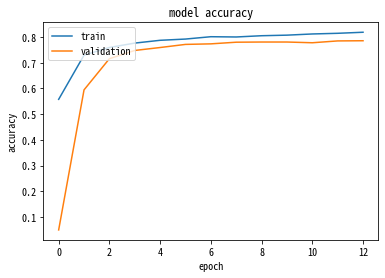

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

## top-5 accuracy

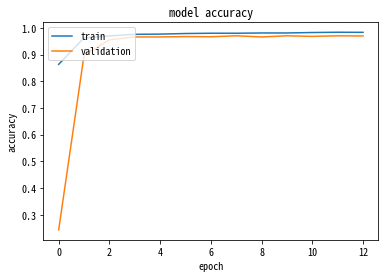

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["top5 accuracy"])
    plt.plot(hist.history["val_top5 accuracy"])
    plt.title("model top5 accuracy")
    plt.ylabel("val_top5 accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

# 隨機抽照片

    0.858  鹽酥雞
    0.065  香酥魚排
    0.019  蒜泥白肉
    0.016  麥克雞塊
    0.011  滷雞腿


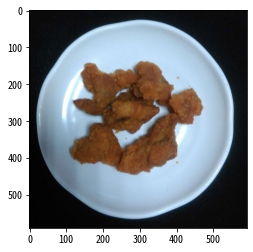

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
lab_rand = class_names[np.random.randint(0,49)] #50種挑其中一類
testdir = os.path.join(base_dir,lab_rand) #選出所在種類的資料路徑
#選出其中一張照片的路徑
testimg=os.path.join(testdir,os.listdir(testdir)[np.random.randint(0,len(testdir)-1)]) 
x = image.load_img(testimg,target_size=(img_height,img_width))
#模型輸出種類及預測機率 top-5
x = np.expand_dims(x, axis = 0) 
pred = model.predict(x)[0]
top_inds = pred.argsort()[::-1][:5]
for i in top_inds:
  print('    {:.3f}  {}'.format(pred[i], class_names[i]))
plt.subplot(1, 1, 1)
image = cv2.imread(testimg)
image = image[:,:,::-1]
plt.imshow(image)